## VAEs on MNIST

#### Imports

In [1]:
import os

import torch
import torch.utils.data as tdata
import torchvision
import torchvision.transforms as T

from vaes_ptorch import (
    CNN,
    DeCNN,
    GaussianModel,
    GaussianVAE,
    TrainArgs,
    get_mlp,
    train,
)
from vaes_ptorch.args import DivAnnealing
from vaes_ptorch.train_vae import evaluate
from vaes_ptorch.utils import show

#### Experiment parameters

In [2]:
latent_dim = 2

lr = 1e-3
batch_size = 128
num_epochs = 10

print_every = 50
eval_every = 1

info_vae = True
# info_vae = False
start_scale = 1.0
end_scale = 1.0
# start_scale = 0.01
# end_scale = 0.01
start_epochs = 0
linear_epochs = 0

in_channels = 1
kernel_sizes = [5, 5]
out_channels = [16, 32]
rev_out_channels = [16, 2]

#### Getting the training data

In [3]:
dataset = torchvision.datasets.MNIST(
    root=os.path.expanduser("~/vaes_ptorch/data"),
    train=True,
    download=True,
    transform=T.ToTensor(),
)

train_size = int(len(dataset) * 0.7)
eval_size = len(dataset) - train_size
train_data, eval_data = tdata.random_split(
    dataset,
    [train_size, eval_size],
    generator=torch.Generator().manual_seed(15),
)

train_loader = tdata.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True
)
eval_loader = tdata.DataLoader(
    dataset=eval_data, batch_size=batch_size, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root=os.path.expanduser("~/vaes_ptorch/data"),
    train=False,
    download=True,
    transform=T.ToTensor(),
)
test_loader = tdata.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=True
)

/home/arnaud15/miniconda3/envs/ptorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630778054/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Setting up the VAE model

In [4]:
encoder = GaussianModel(
    model=CNN(
        in_channels=1,
        out_channels=out_channels,
        kernel_sizes=kernel_sizes,
        bn=True,
        f_map_size=7,
        out_dim=latent_dim * 2,
    ),
    out_dim=latent_dim,
    min_var=1e-2,
)
decoder = GaussianModel(
    model=DeCNN(
        in_dim=latent_dim,
        f_map_size=7,
        channel_size=32,
        out_channels=rev_out_channels,
        kernel_sizes=kernel_sizes,
        bn=True,
    ),
    out_dim=1,
    min_var=0.0,
    split_dim=1,
)
vae = GaussianVAE(encoder=encoder, decoder=decoder)

#### Initializing the optimizer and training arguments

In [5]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)

train_args = TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    eval_every=eval_every,
    smoothing=0.9,
)

### Training

In [6]:
train(
    train_data=train_loader,
    vae=vae,
    optimizer=optimizer,
    args=train_args,
    eval_data=eval_loader,
)

Step: 0 | Loss: 0.17035 | Div scale: 1.000
NLL: 0.09087 | MMD-div: 0.07948
Step: 50 | Loss: 0.07224 | Div scale: 1.000
NLL: 0.04276 | MMD-div: 0.02584
Step: 100 | Loss: 0.06176 | Div scale: 1.000
NLL: 0.03593 | MMD-div: 0.02090
Step: 150 | Loss: 0.05581 | Div scale: 1.000
NLL: 0.03135 | MMD-div: 0.00676
Step: 200 | Loss: 0.04692 | Div scale: 1.000
NLL: 0.03099 | MMD-div: 0.01511
Step: 250 | Loss: 0.05986 | Div scale: 1.000
NLL: 0.03141 | MMD-div: 0.03573
Step: 300 | Loss: 0.05641 | Div scale: 1.000
NLL: 0.03169 | MMD-div: 0.02122
ELBO at the end of epoch #1 is 0.03284
Step: 350 | Loss: 0.04692 | Div scale: 1.000
NLL: 0.03293 | MMD-div: 0.01978
Step: 400 | Loss: 0.05225 | Div scale: 1.000
NLL: 0.03242 | MMD-div: 0.00888
Step: 450 | Loss: 0.05286 | Div scale: 1.000
NLL: 0.03172 | MMD-div: 0.02144
Step: 500 | Loss: 0.04855 | Div scale: 1.000
NLL: 0.03019 | MMD-div: 0.01250
Step: 550 | Loss: 0.05342 | Div scale: 1.000
NLL: 0.03088 | MMD-div: 0.02462
Step: 600 | Loss: 0.04532 | Div scale: 1

### Testing

In [7]:
evaluate(test_loader, vae)

0.029786685080845143

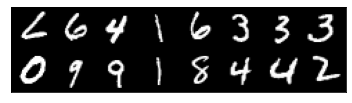

In [8]:
input_images = next(iter(test_loader))[0][:16]
show(input_images)

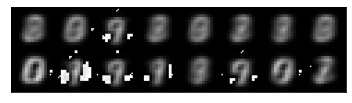

In [9]:
reconstructed_images = vae(input_images)
show(reconstructed_images.mu_x)